In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext autotime

from ngram import *
from baselines import *
from error_analysis import *
pd.options.mode.chained_assignment = None

### Load Annotated Data

In [2]:
task = 'aggression'
xtype = 'comments'
ytype = 'plurality'
n_classes = 3

time: 1.96 ms


In [3]:
data = load_comments_and_labels(task)
X_train, y_train = assemble_data(data, xtype, ytype, splits = ['train'])
X_test, y_test = assemble_data(data, xtype, 'empirical_dist', splits = ['test'])

time: 1min 53s


### Hyper-Parameter tuning

In [4]:
cv_pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')),
])

time: 1.44 ms


In [5]:
param_grid = {
    'vect__max_features': (500, 5000, 10000, 50000, None), 
    'vect__ngram_range': ((1,5),),  
    'vect__analyzer' : ('char',), 
}

tune (X_train, y_train, cv_pipeline, param_grid, roc_scorer, n_jobs=8, verbose=True)


Best parameters set found:
{'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': 50000} 0.935458421105


Grid scores:
0.89329 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': 500}
0.92611 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': 5000}
0.92932 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': 10000}
0.93546 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': 50000}
0.93436 (+/-0.00000) for {'vect__ngram_range': (1, 5), 'vect__analyzer': 'char', 'vect__max_features': None}
time: 5min 43s


### Eval Best Pipeline

In [6]:
optimal_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range = (1,5), analyzer = 'char', max_features = 10000)),
    ('tfidf', TfidfTransformer(sublinear_tf=True,norm='l2')),
    ('clf', LogisticRegression(C = 5.0, solver = 'lbfgs', multi_class= 'multinomial')),
])

time: 14.1 ms


In [7]:
model = optimal_pipeline.fit(X_train, y_train)
roc_df, spearman_df = test_cross(model, data, xtype)

time: 4min 26s


In [8]:
roc_df

,random,blocked,both
user,0.908797,0.919859,0.926557
article,0.847770,0.915007,0.892021
both,0.905407,0.927169,0.929455


time: 13 ms


In [9]:
spearman_df

,random,blocked,both
user,0.590295,0.751878,0.755367
article,0.266716,0.495796,0.437153
both,0.447933,0.687585,0.654286


time: 7.61 ms


### Does Adding Blocked Data Help predicting on Random Data?

#### User

In [10]:
train_params = [
                {'nss': ['user'],
                 'samples': ['random']},
                {'nss': ['user'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['user'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'nss': ['user'], 'samples': ['random']}
Test:  {'nss': ['user'], 'samples': ['random']} 

	ROC: 0.882
	Spearman: 0.582

Train:  {'nss': ['user'], 'samples': ['random', 'blocked']}
Test:  {'nss': ['user'], 'samples': ['random']} 

	ROC: 0.908
	Spearman: 0.589
time: 1min 47s


#### Article

In [11]:
train_params = [
                {'nss': ['article'],
                 'samples': ['random']},
                {'nss': ['article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['article'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'nss': ['article'], 'samples': ['random']}
Test:  {'nss': ['article'], 'samples': ['random']} 

	ROC: 0.811
	Spearman: 0.220

Train:  {'nss': ['article'], 'samples': ['random', 'blocked']}
Test:  {'nss': ['article'], 'samples': ['random']} 

	ROC: 0.831
	Spearman: 0.228
time: 1min 41s


## Does adding random and blocked data from one namespace help predict on random data from the other namespace?

#### User

In [12]:
train_params = [
                {'nss': ['user'],
                 'samples': ['random', 'blocked']},
                {'nss': ['user', 'article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['user'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'nss': ['user'], 'samples': ['random', 'blocked']}
Test:  {'nss': ['user'], 'samples': ['random']} 

	ROC: 0.908
	Spearman: 0.589

Train:  {'nss': ['user', 'article'], 'samples': ['random', 'blocked']}
Test:  {'nss': ['user'], 'samples': ['random']} 

	ROC: 0.909
	Spearman: 0.590
time: 3min 38s


#### Article

In [13]:
train_params = [
                {'nss': ['article'],
                 'samples': ['random', 'blocked']},
                {'nss': ['user', 'article'],
                 'samples': ['random', 'blocked'] }
                ]

test_params =  [
                {'nss': ['article'],
                 'samples': ['random']}
                ]

test_custom_cross(optimal_pipeline, data, xtype, ytype, train_params, test_params)


Train:  {'nss': ['article'], 'samples': ['random', 'blocked']}
Test:  {'nss': ['article'], 'samples': ['random']} 

	ROC: 0.831
	Spearman: 0.228

Train:  {'nss': ['user', 'article'], 'samples': ['random', 'blocked']}
Test:  {'nss': ['article'], 'samples': ['random']} 

	ROC: 0.848
	Spearman: 0.267
time: 3min 29s


### Check Calibration

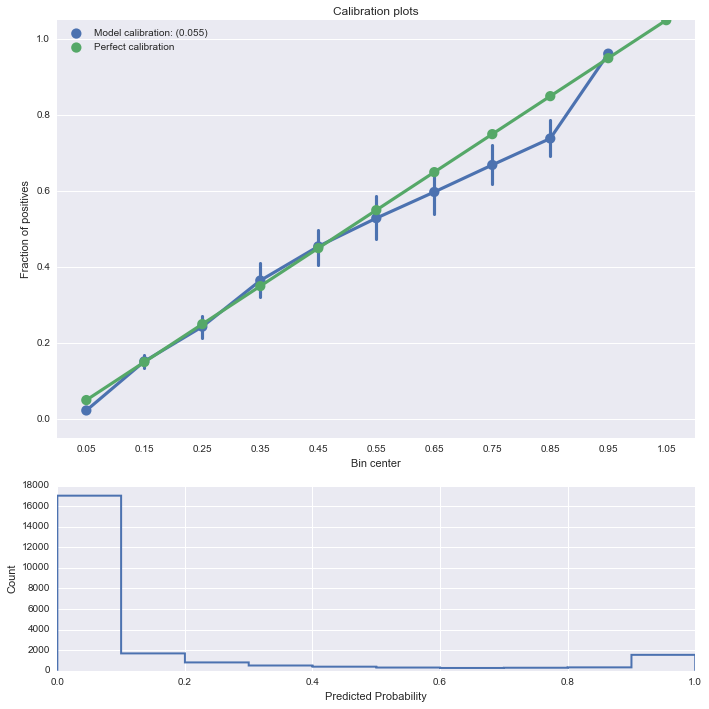

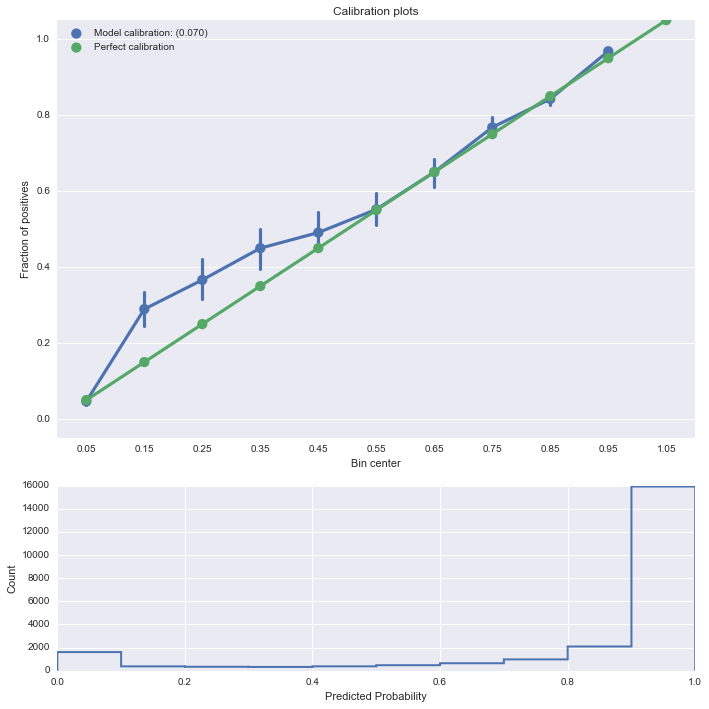

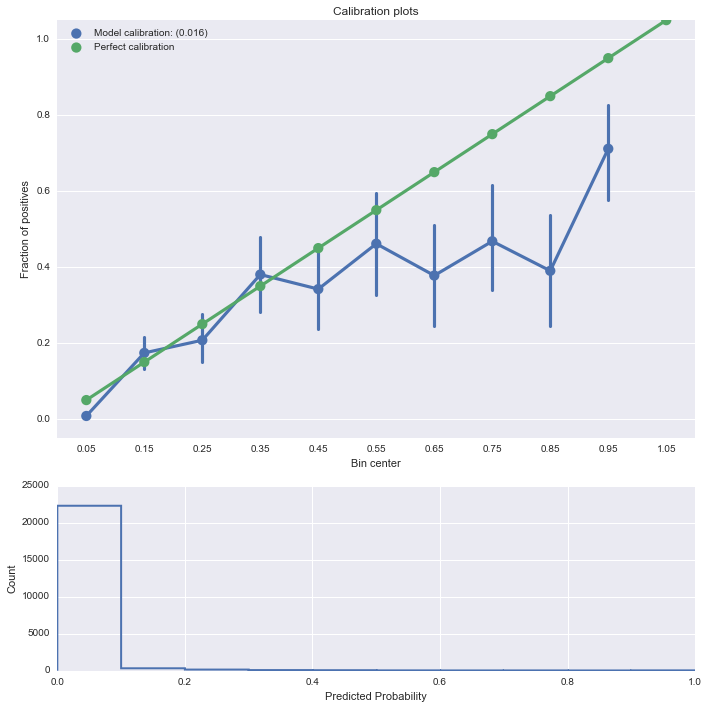

time: 32.3 s


In [14]:
y_test_oh = one_hot(y_test)
y_pred_ed = model.predict_proba(X_test)

if n_classes > 2:
    classes = range(n_classes)
else:
    classes = [1]

for i in classes:
    plt.figure()
    calibration_curve_plotter(y_test_oh[:, i], y_pred_ed[:, i])
    plt.show()

### Error Analysis

In [15]:
for i in classes:
    print('\n\n\nCLASS: ', i)
    over, under = get_errors(X_test, y_test_oh[:, i], y_pred_ed[:, i])
    print('\n\nOVER\n')
    print_errors(over, n=10)
    print('\n\nUNDER\n')
    print_errors(under, n=10)




CLASS:  0


OVER

COMMENT:
 Wow dude you blocked me for stupid stuff I made an edit and I get this warning fix this shit dang Bots Your bot is a peice of shit and it's reverts are counter productive.  It is moronic for you to leave an automated crapbot running.   22:30, 28 May 2006 (UTC)
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 yadavs are kshatriyas wht the hell happend to previous stuff written in the wiki which well defined yadavs,know some anti yadavs have edited the stuff and added whole new crap,mentoning yadavs as shudras is funny shit....some fuckin moron must hv done this..
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 Should this one be added? Roses are RedViolets are BlueI'll Fuck You with a Rake
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 you are dumb Mexican Punk is the god of all gods what is your problem go die in a hole loser
SCORES: Actual: 0.00, Predicted: 1.00, Residual: -1.00


COMMENT:
 i h8 u 

### Learning Curves!
How does adding more training data improve performance?

In [16]:
#ms, metrics = eval_adding_other_data(optimal_pipeline, None, None, X_test, y_test, X_train, y_train, roc_scorer)
#plot_adding_other_data(ms, metrics)

time: 821 µs


### Model Understanding

In [17]:
feature_names = np.array(model.named_steps['vect'].get_feature_names())
for i in classes:
    print('\n\nCLASS: ', i)
    
    try:
        coef = model.named_steps['clf'].coef_[i].ravel()
    except:
        coef = model.named_steps['clf'].coef_.ravel()
    most_pos_idx = np.argsort(coef)[-100:]
    most_pos = feature_names[most_pos_idx]
    print('STRONG POS: ')
    print(most_pos)
    most_neg_idx = np.argsort(coef)[:100]
    most_neg = feature_names[most_neg_idx]
    print('STRONG NEG: ')
    print(most_neg)



CLASS:  0
STRONG POS: 
['hu' ' cr' 'je' 'hate' ' a ' 'athe' 'foo' 'fucki' 'ast' 'dou' ' cock'
 ' his ' ' u ' 'dir' 'tar' 'poo' 'ass.' ' f' ' kil' 's' ' pen' 'zi' '""'
 'go ' 't ad' ' dir' 'you' 're a ' 'lls' 'shit ' 'suck ' 'ry s' ' rac'
 'cun' 'cunt' 'rog' 'ude' ' cunt' 't-' 'off' ' cun' 'nke' '*' ' hate' 'ss'
 'het' 'uck' 'id ' ' off' 'ole' 'ron' 'sil' ' stu' 'u ' ' gay' ' je' 'fag'
 'mn' 'umb' 'cis' 'azi' 'fuck ' ' die' 'id' 'lia' ' dick' 'up' ' bitc'
 'dick' ' hell' 'ck' ' ass ' ' shit' 'hit' 'ass' ' ass' 'peni' 'gay' 'sh'
 'hole' 'dam' 'bitc' 'bitch' ' suck' 'rap' 'suck' ' fuck' ' fuc' 'stu'
 'bag' ' id' 'tard' 'pi' 'oro' 'sex' 'dio' 'fuck' 'shit' 'fuc' 'idi']
STRONG NEG: 
['ello' '. ' 'hank' 'thank' 'ank' ' up' 'uff' 'llo' 'yn' 'ide' 'so' 'assu'
 ' whol' ' pic' 'ank y' ' more' 'stud' ' gra' 't ge' ')' ' ran' 'uf'
 'hank ' 'whol' 'lp' 'fan' 'log' 'esi' 'cro' 'ture' '|' ' stud' ' hol' ') '
 'y he' 'ping ' 'dur' ' "' 'unl' 'ssu' 'ype' 'work' 'ion' 'grea' ']' 'e na'
 ' gl' ' but ' 

### Final Model

In [18]:
X, y = assemble_data(data, xtype, ytype)
final_model = optimal_pipeline.fit(X, y)
joblib.dump(final_model, '../../models/%s_ngram.pkl' % task)

['../../models/aggression_ngram.pkl',
 '../../models/aggression_ngram.pkl_01.npy',
 '../../models/aggression_ngram.pkl_02.npy',
 '../../models/aggression_ngram.pkl_03.npy',
 '../../models/aggression_ngram.pkl_04.npy',
 '../../models/aggression_ngram.pkl_05.npy',
 '../../models/aggression_ngram.pkl_06.npy']

time: 3min 53s
